In [2]:
# Import libraries here
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoRegResultsWrapper

In [3]:
# load the data
from google.colab import files
uploaded=files.upload()

Saving BitcoinPrice.csv to BitcoinPrice.csv


In [4]:
df=pd.read_csv('BitcoinPrice.csv')
y=df.set_index('Date')
y.head()

,Price
Date,
2018-08-25 00:00:00,6719.429231
2018-08-26 00:00:00,6673.274167
2018-08-27 00:00:00,6719.266154
2018-08-28 00:00:00,7000.040000
2018-08-29 00:00:00,7054.276429


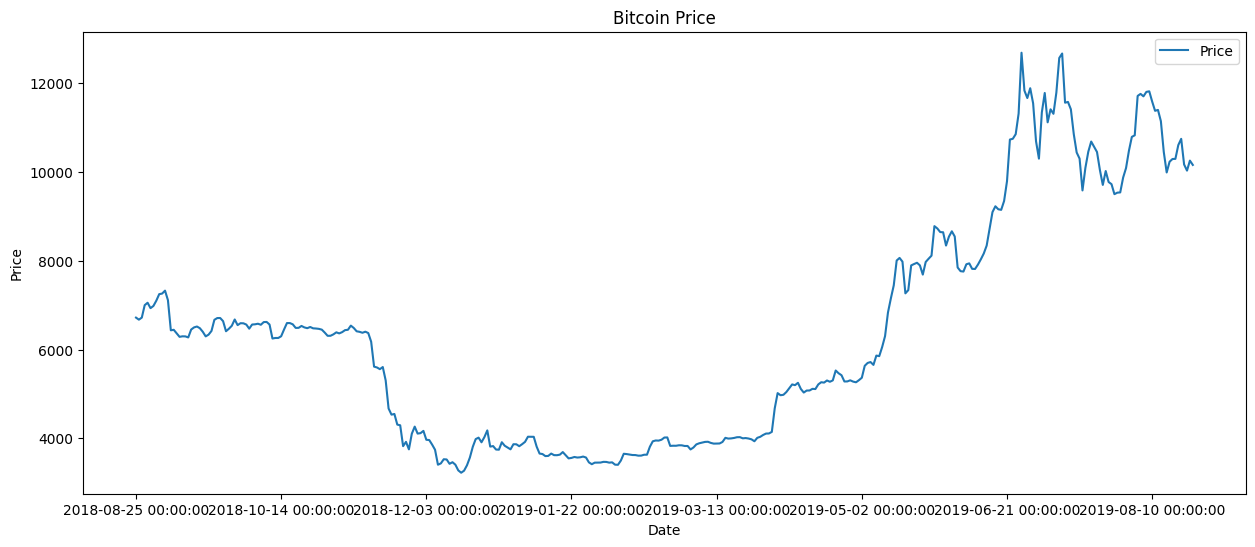

In [5]:
# time series plot
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel='Date', ylabel='Price', title='Bitcoin Price',ax=ax);

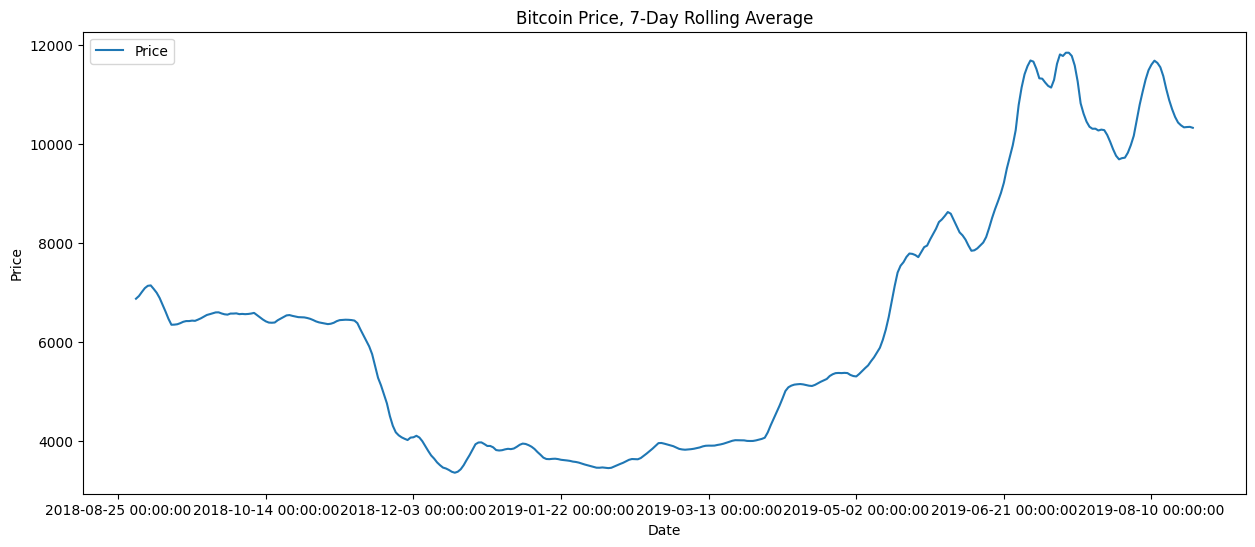

In [6]:
# rolling average
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(7).mean().plot(ax=ax, xlabel='Date', ylabel='Price', title='Bitcoin Price, 7-Day Rolling Average');

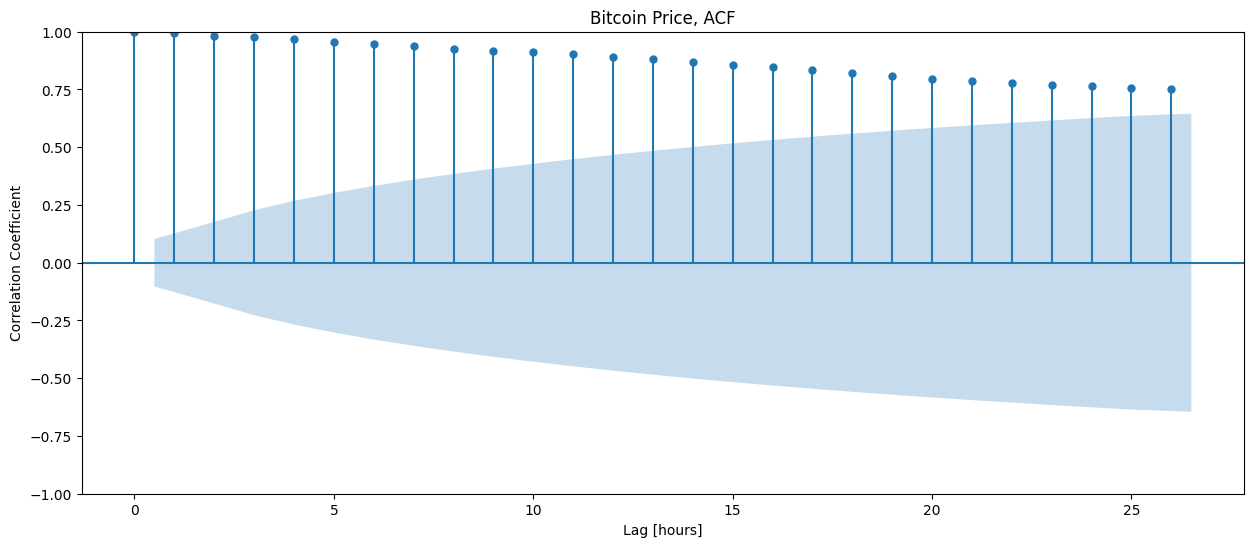

In [7]:
# acf plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel('Lag [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Bitcoin Price, ACF');

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


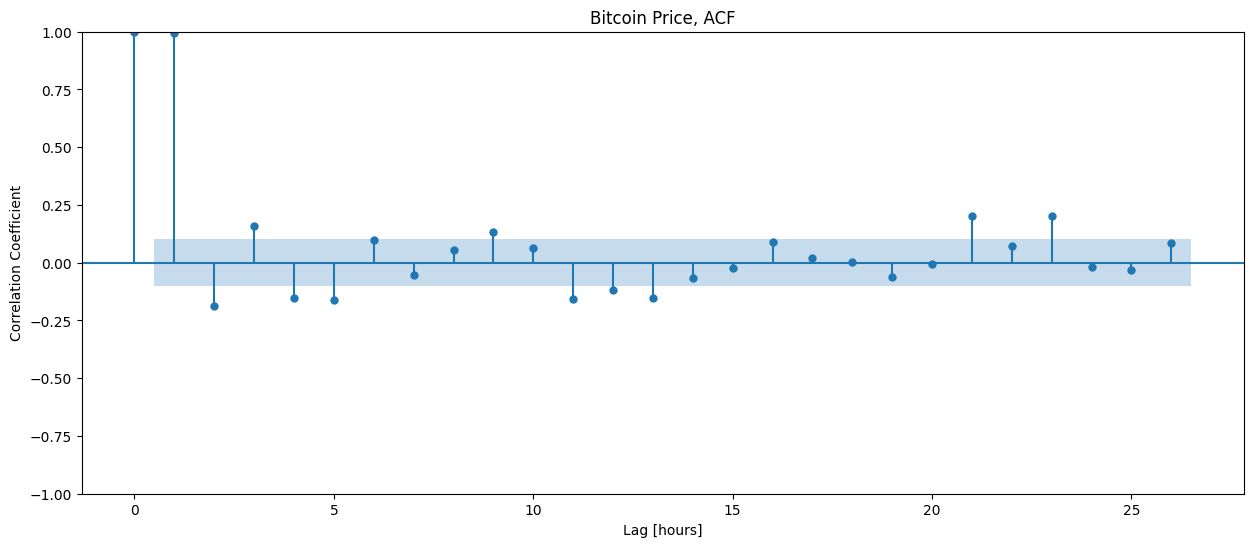

In [8]:
# pacf plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel('Lag [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Bitcoin Price, ACF');

In [9]:
# split
cutoff_test = int(len(y) * .9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (328, 1)
y_test shape: (37, 1)


In [10]:
# baseline model
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: Price    5871.045294
dtype: float64
Baseline MAE: 1821.3815515820468


In [11]:
# iterate
p_params = range(1, 24)
maes = []
for p in p_params:
    model= AutoReg(y_train, lags=p).fit()
    y_pred= model.predict().dropna()
    mae=mean_absolute_error(y_train.iloc[p:],y_pred)
    maes.append(mae)
    pass
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f

1    126.207795
2    125.367170
3    126.821451
4    125.796850
5    127.185985
Name: mae, dtype: float64

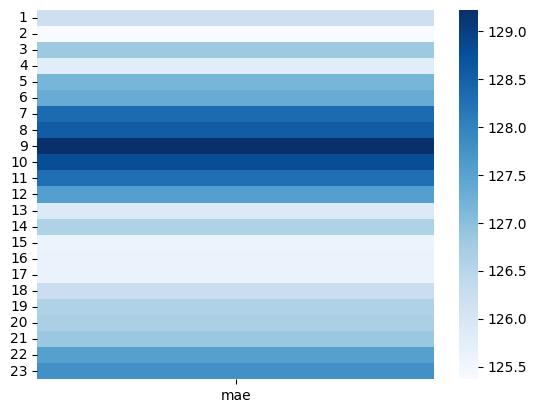

In [12]:
mae_df=pd.DataFrame(mae_series)
sns.heatmap(mae_df,cmap='Blues');

In [13]:
best_p = 2
best_model = AutoReg(y_train, lags=best_p).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [14]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

Date
2018-08-27 00:00:00     45.098332
2018-08-28 00:00:00    265.918508
2018-08-29 00:00:00      4.054016
2018-08-30 00:00:00   -137.220928
2018-08-31 00:00:00     60.269779
Name: residuals, dtype: float64

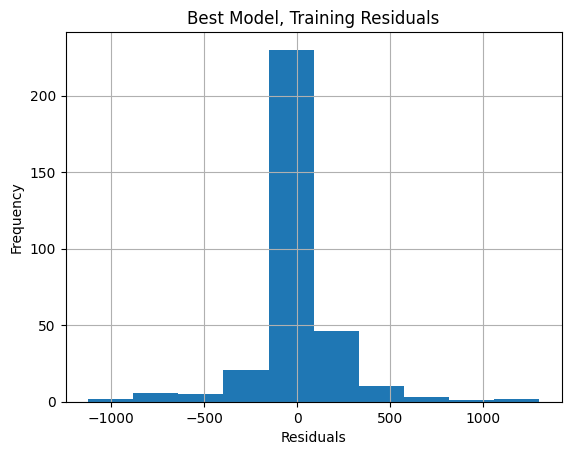

In [15]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Best Model, Training Residuals');

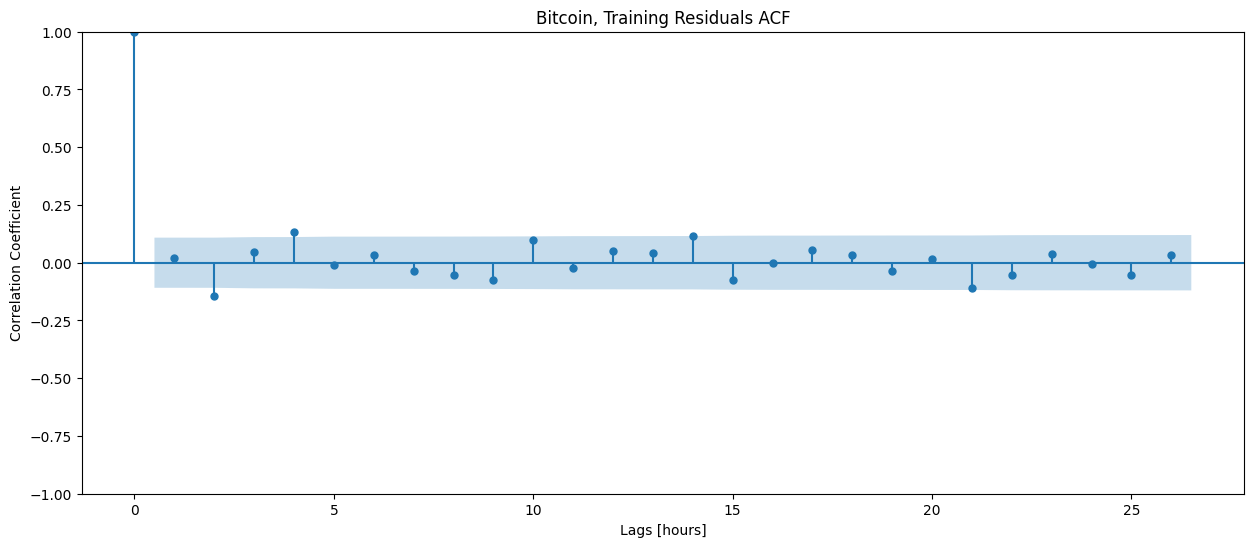

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
plt.xlabel('Lags [hours]')
plt.ylabel('Correlation Coefficient')
plt.title('Bitcoin, Training Residuals ACF');

In [23]:
# evaluate model
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test.iloc[i])
y_pred_wfv.index = y_test.index
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "Date"
y_pred_wfv.head()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
<ipython-input-23-e650446c5c8a>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred_wfv = y_pred_wfv.append(next_pred)
<ipython-input-23-e650446c5c8a>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history = history.append(y_test.iloc[i])
/usr/local/lib/python3.9

Date
0    10172.924966
1    10519.612898
2    10730.935501
3    10556.374068
4    10434.411969
Name: prediction, dtype: float64

In [30]:
# communicate results
df_pred_test = pd.DataFrame({'y_test': y_test.values.reshape(-1), 'y_pred_wfv': y_pred_wfv})
fig = px.line(df_pred_test)
fig.update_layout(
    title="Bitcoin, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()
